In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Set experiment(s) to analyze


In [7]:
exp_ids=['2018_04_13_14_01_01_Scanning 2D MOT freq in loading phase. Readout extended']
assorted={}
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_04_13/2018_04_13_14_01_01_Scanning 2D MOT freq in loading phase. Readout extended/qdp.txt


<IPython.core.display.Javascript object>


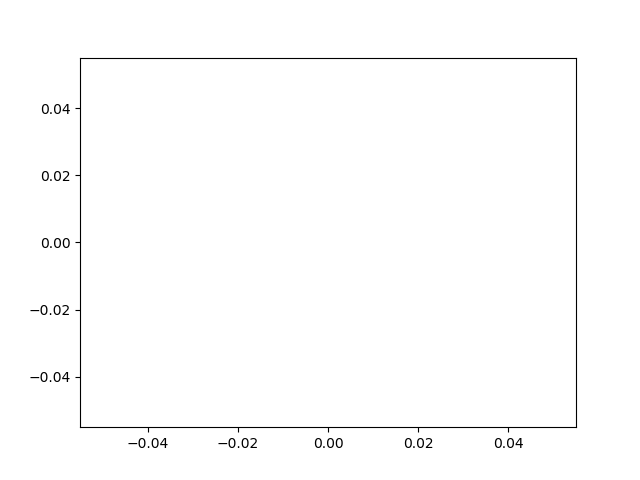

[1520546411.124, 1520546478.074, 1520546550.018, 1520546620.553, 1520546686.233, 1520546757.85, 1520546827.612, 1520546897.208, 1520546965.496, 1520547034.524, 1520547102.877, 1520547171.927, 1520547240.467, 1520547311.035, 1520547380.986, 1520547449.323, 1520547517.614, 1520547586.218, 1520547650.276, 1520547720.134, 1520547788.274, 1520547856.561, 1520547925.185, 1520547993.974, 1520548062.32, 1520548130.63, 1520548198.925, 1520548267.937, 1520548336.685, 1520548405.299, 1520548473.694, 1520548542.236, 1520548610.366, 1520548678.733, 1520548742.899, 1520548812.126, 1520548880.669, 1520548948.595, 1520549016.988, 1520549085.292, 1520549153.761, 1520549222.089, 1520549291.525, 1520549360.713, 1520549429.592, 1520549498.201, 1520549567.117, 1520549635.968, 1520549704.664, 1520549773.226, 1520549841.707, 1520549909.844, 1520549977.951, 1520550046.528, 1520550115.321, 1520550185.807, 1520550254.398, 1520550322.735, 1520550391.701, 1520550461.186, 1520550529.662, 1520550598.593, 1520550667

<ErrorbarContainer object of 3 artists>

In [9]:
roi=1
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
xdata=flatten(assorted['timestamps'])
ydata=np.array(flatten(assorted['retentions'][roi]))
err=np.array(flatten(assorted['errors'][roi]))
fig, ax = plt.subplots()
#print xdata
ax.errorbar(xdata,ydata,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
#xfmt=md.DateFormatter('%H:%M')

In [ ]:
#assorted camera data analysis

assorted={}
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


<IPython.core.display.Javascript object>


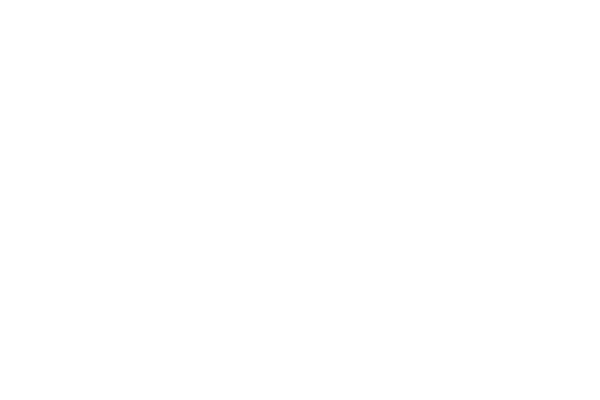

NameError: name 'retention' is not defined

In [5]:
savefig=False
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
fit_guesses=[30,0.4,2,0,0.5]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    data = []
    timedata=[]
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(dates,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
    ax.xaxis.set_major_formatter(xfmt)
    datemin = dt.datetime(2018, 3, 5,0,0,0)
    datemax = dt.datetime(2018, 3, 5,4,0,0)
    ax.set_xlim(datemin, datemax)

# Analyzing experiments without atoms

In [28]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
 'timestamp_measurements',
 'timestamp_iteration']

exp_ids=['2018_04_15_12_24_02_Open loop, no atom',
         '2018_04_15_14_40_02_Open loop, no atom',
         '2018_04_15_16_27_01_Open loop, no atom',
         '2018_04_15_18_13_15_Open loop, no atom',
         '2018_04_15_19_59_37_Open loop, no atom',
         '2018_04_15_21_46_46_Open loop, no atom',
         '2018_04_15_23_33_16_Open loop, no atom'
#          '2018_04_16_15_17_15_780 Ramsey tgap scan sitting between sites',
#          '2018_04_16_16_55_09_780 Ramsey tgap scan sitting between sites',
#          '2018_04_16_20_20_44_again, 780A Ramsey',
#          '2018_04_16_20_49_58_again, 780A Ramsey',
#          '2018_04_16_21_23_58_again, 780A Ramsey',
#          '2018_04_16_21_48_55_again, 780A Ramsey',
#          '2018_04_16_22_11_57_again, 780A Ramsey',
#          '2018_04_16_22_49_47_again, 780A Ramsey'
        ]
         
data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_12_24_02_Open loop, no atom/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_14_40_02_Open loop, no atom/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_16_27_01_Open loop, no atom/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_18_13_15_Open loop, no atom/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_19_59_37_Open loop, no atom/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_21_46_46_Open loop, no atom/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_15/2018_04_15_23_33_16_Open loop, no atom/qdp.txt


<IPython.core.display.Javascript object>


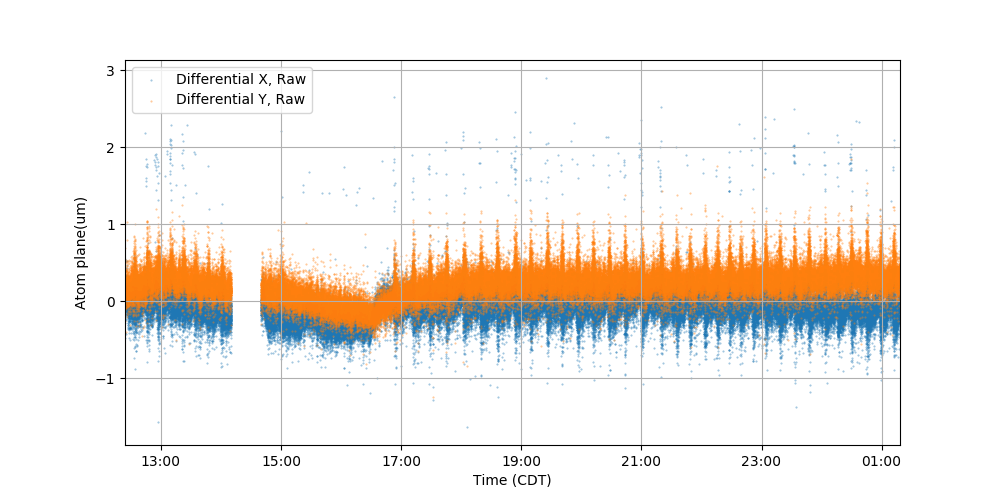

In [29]:
# xfmt=md.DateFormatter('%H:%M')
# dotsize=1
# figW=10
# figH=5
# fig, ax = plt.subplots()
# fig.set_size_inches(figW,figH)
# flattendedtimestamps=np.array(flatten(data[keylist[4]]))
# dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps]

# flatteneddata0=np.array(flatten(data[keylist[0]]))
# flatteneddata2=np.array(flatten(data[keylist[2]]))
# ax.xaxis.set_major_formatter(xfmt)
# data_to_plot=flatteneddata0-flatteneddata2
# #data2_to_plot=np.mean(data_to_plot.reshape(-1,100),1)
# ax.scatter(dates,data_to_plot,s=dotsize)
# #ax.plot(dates,data2_to_plot)
# ax.set_xlim(dates[0],dates[-1])

# fig, ax = plt.subplots()
# fig.set_size_inches(figW,figH)
# flatteneddata1=np.array(flatten(data[keylist[1]]))
# flatteneddata3=np.array(flatten(data[keylist[3]]))
# data_to_plot=flatteneddata1-flatteneddata3
# ax.scatter(dates,data_to_plot,s=dotsize)
# ax.xaxis.set_major_formatter(xfmt)
# ax.set_xlim(dates[0],dates[-1])
# Raw plotting
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=0.2,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=0.2,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:
    plt.savefig('Alignment_over_night.png')

<IPython.core.display.Javascript object>


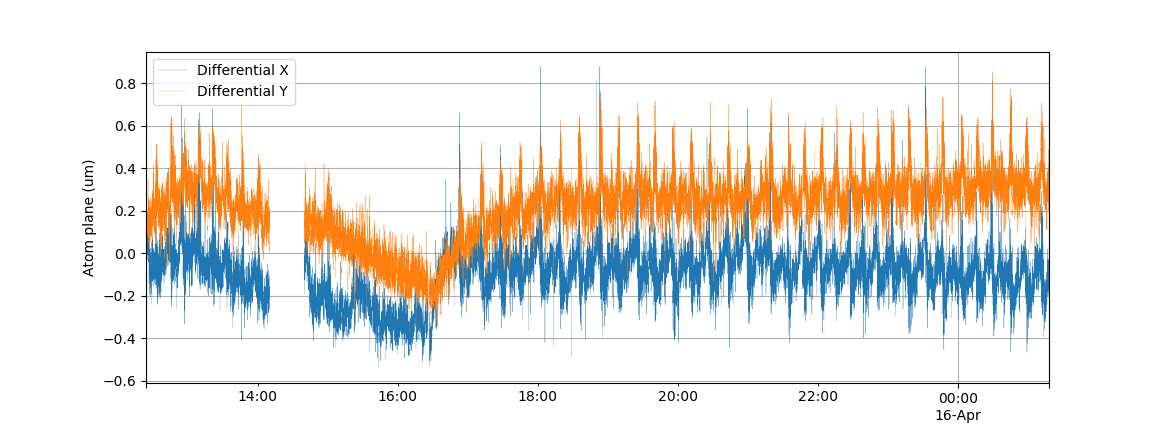

In [37]:
# Using Pandas
savefig=True
data_cutoff=0
flattendedtimestamps=np.array(flatten(data[keylist[4]]))
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

samplerate='2S'
offsetX=(flatteneddata0-flatteneddata2)[0]
offsetY=(flatteneddata1-flatteneddata3)[0]
df=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY,
                 'Red X': flatteneddata0,
                 'Red Y': flatteneddata1,
                 'FORT X': flatteneddata2,
                 'FORT Y': flatteneddata3
                },index=dates)

## 
data_to_plot2=df.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['Differential X','Differential Y'],lw=0.2,marker='.',markersize=0.02)
#data_to_plot2.plot(y='Differential Y',lw=0.2)
#ax.set_xlabel('Atom plane (um)')
ax.set_ylabel('Atom plane (um)')
ax.grid()
ax.legend()
plt.savefig('Alignment_20180415.png')

In [8]:
data_to_plot2

,Differential X,Differential Y
2018-04-15 12:24:00,0.033436,-0.086155
2018-04-15 12:24:10,0.096204,0.154932
2018-04-15 12:24:20,0.095273,0.180056
2018-04-15 12:24:30,0.098937,0.126298
2018-04-15 12:24:40,0.109810,0.174550
2018-04-15 12:24:50,0.130673,0.216353
2018-04-15 12:25:00,0.015736,0.119034
2018-04-15 12:25:10,0.032584,0.134498
2018-04-15 12:25:20,0.030223,0.127938
2018-04-15 12:25:30,0.055167,0.133412


In [22]:
# Allan 
tau_list=range(1,10000)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    #print i
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass

<IPython.core.display.Javascript object>


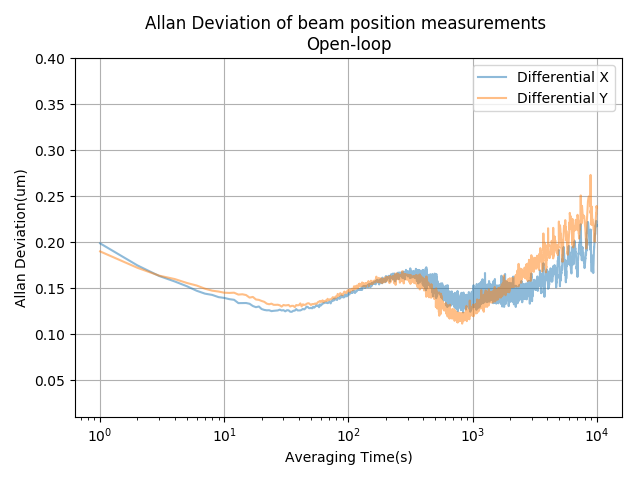

In [23]:
fig, ax = plt.subplots()
#xdata=tau_lists
#for key in var_list:
for key in ['Differential X','Differential Y']:
    ax.semilogx(tau_list, np.sqrt(0.5*np.array(var_list[key])),label=key,alpha=0.5)
#ax.semilogx(tau_list, np.sqrt(Yvar_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Xvariance_list),label='Diff X',alpha=0.5)
# ax.plot(xdata,np.sqrt(Yvariance_list),label='Diff Y',alpha=0.5)
ax.legend()
#ax.set_xlim(1,)
ax.set_title('Allan Deviation of beam position measurements \nOpen-loop')
ax.set_xlabel('Averaging Time(s)')
ax.set_ylabel('Allan Deviation(um)')
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.01,0.4)
ax.grid()
plt.tight_layout()
if savefig:
    plt.savefig('AllanDeviation_Openloop.png')
    plt.savefig('AllanDeviation_Openloop.pdf')